In [201]:
from typing import TypedDict, Annotated,Optional
from langgraph.graph import START,END,StateGraph
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import InMemorySaver
import os
import requests

load_dotenv()

os.environ['LANGCHAIN_PROJECT']="Langgraph-Gitlab-Projects"

GITLAB_URL= os.environ["GITLAB_URL"]
# PROJECT_ID = os.getenv("PROJECT_ID")
TOKEN = os.getenv("GITLAB_PAT")

headers = {"PRIVATE-TOKEN": TOKEN}

gpt_llm= ChatOpenAI(model="gpt-4o-mini")
class ToolCaller(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    current_project_id: Optional[str] 

@tool
def fetch_gitlab_issues():
    """
    Tool to fetch all the open and closed issues in a specific gitlab project.
    IMPORTANT: This requires a project to be set. If no project is currently set,
    you should first ask the user which project they want to check, or list all 
    projects using fetch_all_projects.
    """
    project_id = PROJECT_ID
    headers = {"PRIVATE-TOKEN": TOKEN}
    url = f"{GITLAB_URL}/{project_id}/issues"

    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        issues = response.json()
        return [{"iid": i["iid"], "title": i["title"], "state": i["state"],"description": i["description"], 
                 "web_url": i["web_url"], "created_at":i["created_at"],"closed_at":i["closed_at"],"closed_by":i["author"]["username"]} 
                 for i in issues]
    else:
        return [{"error": response.text}]


@tool
def close_gitlab_issue(issue_iid: str) -> dict:
    """
    Based on the issue ID, the function will help close the open tickets.
    If user doesn't provide an issue_iid, prompt them to provide the issue_iid.
    """
    project_id = PROJECT_ID
    headers = {"PRIVATE-TOKEN": TOKEN}
    url = f"{GITLAB_URL}/{project_id}/issues/{issue_iid}"
    data = {"state_event": "close"}

    response = requests.put(url, headers=headers, data=data)

    if response.status_code == 200:
        return {"message": f"Issue #{issue_iid} closed successfully."}
    else:
        return {"error": response.text}

@tool
def fetch_all_projects():
    """Fetch all the projects from gitlab. If there are many more projects- safely prompt user any 5 projects only."""
    headers = {"PRIVATE-TOKEN": TOKEN}
    url = GITLAB_URL
    params = {
    "membership": True,
    "simple": True,
    "per_page": 100
    }
    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        projects = response.json()
        
        return [{"project_name": p["name"], "project_id": p["id"], } 
                 for p in projects]
    
    else:
        return [{"error": response.text}]

@tool
def add_labels_to_issue(issue_iid: str, labels: str):
    """
    Add new labels to a GitLab issue without removing existing ones. If project id or project name and issue iid is not provided, ask user to provide it.
    
    Args:
        issue_iid: The issue IID (internal ID) to update
        labels: Comma-separated string of labels to ADD (e.g., "bug,high-priority")
                This will ADD these labels to any existing labels.
    
    Example: add_labels_to_issue("42", "urgent,needs-review")
    """
    project_id = PROJECT_ID
    if not project_id:
        return {"error": "No project selected. Please set a project first."}
    
    headers = {"PRIVATE-TOKEN": TOKEN}
    
    # First, get current labels
    get_url = f"{GITLAB_URL}/{project_id}/issues/{issue_iid}"
    get_response = requests.get(get_url, headers=headers)
    
    if get_response.status_code != 200:
        return {"error": f"Failed to fetch current labels: {get_response.text}"}
    
    current_labels = get_response.json().get("labels", [])
    new_labels_list = [label.strip() for label in labels.split(",")]
    
    # Combine current and new labels (remove duplicates)
    combined_labels = list(set(current_labels + new_labels_list))
    combined_labels_str = ",".join(combined_labels)
    
    # Update with combined labels
    put_url = f"{GITLAB_URL}/{project_id}/issues/{issue_iid}"
    data = {"labels": combined_labels_str}
    
    response = requests.put(put_url, headers=headers, data=data)
    
    if response.status_code == 200:
        return {"message": f"Added labels to issue #{issue_iid}. Current labels: {combined_labels_str}"}
    else:
        return {"error": response.text}

@tool
def remove_labels_from_issue(issue_iid: str, labels: str):
    """
    Remove specific labels from a GitLab issue. If project id or project name and issue iid is not provided, ask user to provide it.
    
    Args:
        issue_iid: The issue IID (internal ID) to update
        labels: Comma-separated string of labels to REMOVE (e.g., "bug,wontfix")
    
    Example: remove_labels_from_issue("42", "wontfix,duplicate")
    """
    project_id = PROJECT_ID
    if not project_id:
        return {"error": "No project selected. Please set a project first."}
    
    headers = {"PRIVATE-TOKEN": TOKEN}
    
    # First, get current labels
    get_url = f"{GITLAB_URL}/{project_id}/issues/{issue_iid}"
    get_response = requests.get(get_url, headers=headers)
    
    if get_response.status_code != 200:
        return {"error": f"Failed to fetch current labels: {get_response.text}"}
    
    current_labels = get_response.json().get("labels", [])
    labels_to_remove = [label.strip() for label in labels.split(",")]
    
    # Remove specified labels
    remaining_labels = [label for label in current_labels if label not in labels_to_remove]
    remaining_labels_str = ",".join(remaining_labels)
    
    # Update with remaining labels
    put_url = f"{GITLAB_URL}/{project_id}/issues/{issue_iid}"
    data = {"labels": remaining_labels_str}
    
    response = requests.put(put_url, headers=headers, data=data)
    
    if response.status_code == 200:
        return {"message": f"Removed labels from issue #{issue_iid}. Current labels: {remaining_labels_str}"}
    else:
        return {"error": response.text}

@tool
def update_issue_labels(issue_iid: str, labels: str):
    """
    Update or add labels to a GitLab issue. If project id or project name and issue iid is not provided, ask user to provide it.
    
    Args:
        issue_iid: The issue IID (internal ID) to update
        labels: Comma-separated string of labels to set (e.g., "bug,high-priority,backend")
                This will REPLACE all existing labels with the new ones.
    
    Example: update_issue_labels("42", "bug,urgent,needs-review")
    """
    project_id = PROJECT_ID
    if not project_id:
        return {"error": "No project selected. Please set a project first."}
    
    headers = {"PRIVATE-TOKEN": TOKEN}
    url = f"{GITLAB_URL}/{project_id}/issues/{issue_iid}"
    data = {"labels": labels}

    response = requests.put(url, headers=headers, data=data)
    
    if response.status_code == 200:
        return {"message": f"Labels updated for issue #{issue_iid} to: {labels}"}
    else:
        return {"error": response.text}

@tool
def add_comment_to_issue(issue_iid: str, comment: str):
    """Add a comment to a GitLab issue.
    If user doesn't provide an issue_iid, prompt them to provide the issue_iid.
    """
    project_id = PROJECT_ID
    headers = {"PRIVATE-TOKEN": TOKEN}
    url = f"{GITLAB_URL}/{project_id}/issues/{issue_iid}/notes"
    data = {"body": comment}

    response = requests.post(url, headers=headers, data=data)
    if response.status_code == 201:
        return {"message": f"Comment added to issue #{issue_iid} successfully."}
    else:
        return {"error": response.text}

@tool
def set_project_id(project_id: str):
    """
    Set the project ID to use for subsequent GitLab operations.
    Call this tool when user wants to work with a specific project.
    """
    return {"status": "success", "message": f"Project ID set to: {project_id}", "project_id": project_id}


tools = [fetch_gitlab_issues,close_gitlab_issue,add_comment_to_issue,fetch_all_projects,set_project_id,
         update_issue_labels,add_labels_to_issue,remove_labels_from_issue]

llm_with_tools= gpt_llm.bind_tools(tools)

def chat_node(state: ToolCaller) -> ToolCaller:
    """LLM node that handles chat + tool calls. 
    """
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}

def tool_node_with_state(state: ToolCaller):
    """Execute tools and update current_project_id if set_project_id was called."""
    result = ToolNode(tools).invoke(state)

    updated_project_id = state.get("current_project_id")
    for msg in result["messages"]:
        if hasattr(msg, "content") and "project_id" in str(msg.content):
            import json
            try:
                content = json.loads(msg.content) if isinstance(msg.content, str) else msg.content
                if isinstance(content, dict) and "project_id" in content:
                    updated_project_id = content["project_id"]
                    global PROJECT_ID
                    PROJECT_ID = updated_project_id
            except:
                pass
    
    return {"messages": result["messages"], "current_project_id": updated_project_id}


graph=StateGraph(ToolCaller)
graph.add_node("chat_node",chat_node)
graph.add_node("tools",tool_node_with_state)

graph.add_edge(START,"chat_node")
graph.add_conditional_edges("chat_node",tools_condition)
graph.add_edge("tools","chat_node")

checkpoint=InMemorySaver()

workflow=graph.compile(checkpointer=checkpoint)


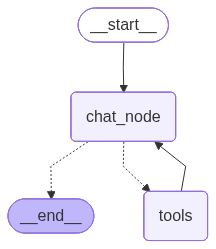

In [202]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [203]:
config={
        "configurable": {"config_name": "GitLab Chatbot"},
        "thread_id": "123"
    }

In [198]:
#workflow.invoke({"messages":"How many issues are opened?"},config=config)

In [199]:
#workflow.invoke({"messages":"For Test_gitlab_2 show me how many opened issues are there?"},config=config)

In [200]:
#workflow.invoke({"messages":"How many issues are opened?"},config=config)

In [204]:
workflow.invoke({"messages":"please help in adding the label as 'status:closed,Delivery quarter:Q3' "},config=config)

{'messages': [HumanMessage(content="please help in adding the label as 'status:closed,Delivery quarter:Q3' ", additional_kwargs={}, response_metadata={}, id='ee31372c-5703-4eef-9828-311977ad5074'),
  AIMessage(content='Could you please provide the issue IID (internal ID) for the issue you want to add the labels to? Also, please confirm if you have a specific project in mind, or if I need to fetch your projects to assist you further.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 623, 'total_tokens': 672, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CVXLRlVBV7gSfHHzaPoqf4vNjr0d2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--660bd11b

In [205]:
workflow.invoke({"messages":"For Test_Gitlab_2, and issue number 4, please help in adding the label as 'status:closed,Delivery quarter:Q3' "},config=config)

{'messages': [HumanMessage(content="please help in adding the label as 'status:closed,Delivery quarter:Q3' ", additional_kwargs={}, response_metadata={}, id='ee31372c-5703-4eef-9828-311977ad5074'),
  AIMessage(content='Could you please provide the issue IID (internal ID) for the issue you want to add the labels to? Also, please confirm if you have a specific project in mind, or if I need to fetch your projects to assist you further.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 623, 'total_tokens': 672, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CVXLRlVBV7gSfHHzaPoqf4vNjr0d2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--660bd11b

In [206]:
workflow.invoke({"messages":"For 64994970 project and issue iid 4, please help in adding the label as status:closed,Delivery quarter:Q3 "},config=config)

{'messages': [HumanMessage(content="please help in adding the label as 'status:closed,Delivery quarter:Q3' ", additional_kwargs={}, response_metadata={}, id='ee31372c-5703-4eef-9828-311977ad5074'),
  AIMessage(content='Could you please provide the issue IID (internal ID) for the issue you want to add the labels to? Also, please confirm if you have a specific project in mind, or if I need to fetch your projects to assist you further.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 623, 'total_tokens': 672, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CVXLRlVBV7gSfHHzaPoqf4vNjr0d2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--660bd11b

In [207]:
workflow.invoke({"messages":"For test_gitlab_2 project and issue iid 2, please help in adding the label as status:Delivered,Delivery Quarter:Q2, also add a comment to the issue as 'UI issue has been fixed with rca provided to the business. Attached email.' "},config=config)


{'messages': [HumanMessage(content="please help in adding the label as 'status:closed,Delivery quarter:Q3' ", additional_kwargs={}, response_metadata={}, id='ee31372c-5703-4eef-9828-311977ad5074'),
  AIMessage(content='Could you please provide the issue IID (internal ID) for the issue you want to add the labels to? Also, please confirm if you have a specific project in mind, or if I need to fetch your projects to assist you further.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 623, 'total_tokens': 672, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CVXLRlVBV7gSfHHzaPoqf4vNjr0d2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--660bd11b

In [208]:
workflow.invoke({"messages":"For first-dockerfile-python-app project and issue iid 2, please help in adding the label as status:In Progress,Delivery Quarter:Q3, also add a comment to the issue as 'The issue has been raised to the support team. Feasability is being carried out.' "},config=config)


{'messages': [HumanMessage(content="please help in adding the label as 'status:closed,Delivery quarter:Q3' ", additional_kwargs={}, response_metadata={}, id='ee31372c-5703-4eef-9828-311977ad5074'),
  AIMessage(content='Could you please provide the issue IID (internal ID) for the issue you want to add the labels to? Also, please confirm if you have a specific project in mind, or if I need to fetch your projects to assist you further.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 623, 'total_tokens': 672, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CVXLRlVBV7gSfHHzaPoqf4vNjr0d2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--660bd11b

In [209]:
workflow.invoke({"messages":"For first-dockerfile-python-app project and issue iid 2 in the same prject, please help in adding the label as status:In Progress,Delivery Quarter:Q3, also add a comment to the issue as 'The issue has been raised to the support team. Feasability is being carried out.' "},config=config)


{'messages': [HumanMessage(content="please help in adding the label as 'status:closed,Delivery quarter:Q3' ", additional_kwargs={}, response_metadata={}, id='ee31372c-5703-4eef-9828-311977ad5074'),
  AIMessage(content='Could you please provide the issue IID (internal ID) for the issue you want to add the labels to? Also, please confirm if you have a specific project in mind, or if I need to fetch your projects to assist you further.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 623, 'total_tokens': 672, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CVXLRlVBV7gSfHHzaPoqf4vNjr0d2', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--660bd11b